In [1]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

In [2]:
def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")

In [275]:
from solvers import agglomeration_grid_2d, agglomeration_pa_2d, breakage_pa_2d, breakage_grid_2d, DaughterGridType
from compress import compress
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy.integrate import trapz
from scipy.stats import binned_statistic, binned_statistic_2d, norm
import pandas as pd
import matplotlib

# Agglomeration

In [276]:
L_edges_0 = np.arange(0, 21, 0.5)
L_edges_1 = np.arange(0, 20, 0.5)
L_edges = (L_edges_0, L_edges_1)
L_edge_diff_area = (L_edges_0[1] - L_edges_0[0]) * (L_edges_1[1] - L_edges_1[0]) 

L_centers_0 = 0.5 * (L_edges_0[:-1] + L_edges_0[1:])
L_centers_1 = 0.5 * (L_edges_1[:-1] + L_edges_1[1:])

L_centers = (L_centers_0, L_centers_1)
Lc0, Lc1 = np.meshgrid(*L_centers)
Lc = np.stack([Lc0, Lc1], axis=-1)
z = (Lc0 ** 2 + Lc1 ** 2) ** (1/2)

n_init = norm.pdf(z, loc=0, scale=3)

dt = 0.1
t_total = 10.
kernel_coef = np.array([1., 1.])
aggl_powers = np.array([2., 1.])

## Grid method

In [277]:
n = n_init.copy()

cnts = [(n * L_edge_diff_area).sum()]
vols = [(n * Lc0**2 * Lc1 * L_edge_diff_area).sum()]
ts = [0]
_d = [0]
pbar = tqdm(total=t_total)
t = 0
while t < t_total:
    B, D = agglomeration_grid_2d(n, L_edges, L_centers, kernel_coef, aggl_powers, min_count=1e-18)
    n += (B - D) * dt
    t += dt
    _d.append((B-D).sum() * L_edge_diff_area)
    assert np.all(n >= 0)
    # assert np.isclose(B.sum() * 2, D.sum())
    pbar.update(dt)
    cnt = (n * L_edge_diff_area).sum()
    vol = (n * Lc0**2 * Lc1 * L_edge_diff_area).sum()
    cnts.append(cnt)
    vols.append(vol)
    ts.append(t)
    # break
pbar.close()

  0%|          | 0/10.0 [00:00<?, ?it/s]

## PA method

In [278]:
N_init = n_init * L_edge_diff_area
N = np.vstack([Lc0.reshape(-1), Lc1.reshape(-1), N_init.reshape(-1)]).T
N = N[N[:, -1] > 0]
N_init = N.copy()
pbar = tqdm(total=t_total)
t = 0
pa_cnts = [N[:, -1].sum()]
pa_ts = [0]
pa_vols = [(N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()]
pa_d = [0]
ginterval = 0.5
N = compress(N, ginterval, aggl_powers, 1, )

while t < t_total:
    v_original = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    Bs, D = agglomeration_pa_2d(N, (0.3, 0.3), kernel_coef, aggl_powers, min_count=1e-9)
    B = np.vstack(Bs)
    pa_d.append(B[:, -1].sum() - D.sum())
    assert np.isclose(D.sum(), B[:, -1].sum()*2) # count rate equal
    assert np.isclose((N[:, 0]**2 * N[:, 1] * D).sum(), (B[:, 0]**2 * B[:, 1] * B[:, -1]).sum())
    N[:, -1] -= dt * D
    assert np.all(N[:, -1] > 0)
    B[:, -1] *= dt
    
    N = np.vstack((N, B))
    v_before_compression = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    assert np.isclose(v_before_compression, v_original)
    N = compress(N, ginterval, aggl_powers, 1, )
    v_after_compression = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    assert np.isclose(v_before_compression, v_after_compression)
    t += dt
    pbar.update(dt)
    pa_cnts.append(N[:, -1].sum())
    pa_ts.append(t)
    pa_vols.append(v_after_compression)
pbar.close()

  0%|          | 0/10.0 [00:00<?, ?it/s]

In [279]:
# store plot variables
aggl_pa = {
    "ts": pa_ts,
    "vols": pa_vols,
    "cnts": pa_cnts,
    "N": N,
    "N_init": N_init
}

aggl_grid = {
    "ts": ts,
    "vols": vols,
    "cnts": cnts,
    "n_init": n_init,
    "n": n,
    "Lc0": Lc0,
    "Lc1": Lc1,
    "area": L_edge_diff_area
}

# Breakage

In [467]:

L_edges_0 = np.linspace(0, 10, 51)
L_edges_1 = np.linspace(0, 10, 50)
L_edges = (L_edges_0, L_edges_1)
L_edge_diff_area = (L_edges_0[1] - L_edges_0[0]) * (L_edges_1[1] - L_edges_1[0])

L_centers_0 = 0.5 * (L_edges_0[:-1] + L_edges_0[1:])
L_centers_1 = 0.5 * (L_edges_1[:-1] + L_edges_1[1:])

L_centers = (L_centers_0, L_centers_1)
Lc0, Lc1 = np.meshgrid(*L_centers)
Lc = np.stack([Lc0, Lc1], axis=-1)
z = (Lc0 ** 2 + Lc1 ** 2) ** (1/2)

n_init = norm.pdf(Lc0, loc=10, scale=0.4) * norm.pdf(Lc1, loc=10, scale=0.4) * 1.

dt = 0.1
t_total = 10.
kernel_coef = np.array([1e-7, 1e-7])
brk_powers = np.array([2., 1.])

In [468]:
t = 0
n = n_init.copy()
cnt = (n * L_edge_diff_area).sum()
vol = (n * Lc0**2 * Lc1 * L_edge_diff_area).sum()
cnts = [cnt]
vols = [vol]
ts = [t]

pbar = tqdm(total=t_total)
while t < t_total:
    B, D = breakage_grid_2d(n, L_edges, L_centers, kernel_coef, brk_powers)
    n += (B - D) * dt
    assert np.all(n >= 0)
    t += dt
    # assert np.isclose(B.sum() * 2, D.sum())
    pbar.update(dt)
    cnt = (n * L_edge_diff_area).sum()
    vol = (n * Lc0**2 * Lc1 * L_edge_diff_area).sum()
    cnts.append(cnt)
    vols.append(vol)
    ts.append(t)
    # break
pbar.close()

  0%|          | 0/10.0 [00:00<?, ?it/s]

In [469]:
N_init = n_init * L_edge_diff_area
N = np.vstack([Lc0.reshape(-1), Lc1.reshape(-1), N_init.reshape(-1)]).T
N = N[N[:, -1] > 0*L_edge_diff_area]
N_init = N.copy()
pbar = tqdm(total=t_total)
t = 0
pa_cnts = [N[:, -1].sum()]
pa_ts = [t]
pa_vols = [(N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()]
while t < t_total:
    v_original = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    Bs, D = breakage_pa_2d(N, kernel_coefs=kernel_coef, dim_powers=brk_powers, min_count=1e-15, daughter_grid_type=DaughterGridType.LINEAR)
    B = np.vstack(Bs)
    assert np.isclose(D.sum()*2, B[:, -1].sum()) # count rate equal
    assert np.isclose((N[:, 0]**2 * N[:, 1] * D).sum(), (B[:, 0]**2 * B[:, 1] * B[:, -1]).sum())
    N[:, -1] -= dt * D
    assert np.all(N[:, -1] > 0)
    B[:, -1] *= dt

    N = np.vstack((N, B))
    v_before_compression = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    assert np.isclose(v_before_compression, v_original)
    N = compress(N, 1.0, brk_powers, 1, )
    v_after_compression = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    assert np.isclose(v_before_compression, v_after_compression)
    t += dt
    pbar.update(dt)
    pa_cnts.append(N[:, -1].sum())
    pa_ts.append(t)
    pa_vols.append(v_after_compression)
pbar.close()

  0%|          | 0/10.0 [00:00<?, ?it/s]

In [470]:
# store plot variables
brk_pa = {
    "ts": pa_ts,
    "vols": pa_vols,
    "cnts": pa_cnts,
    "N": N,
    "N_init": N_init
}

brk_grid = {
    "ts": ts,
    "vols": vols,
    "cnts": cnts,
    "n_init": n_init,
    "n": n,
    "Lc0": Lc0,
    "Lc1": Lc1,
    "area": L_edge_diff_area
}

# Visualize results

In [471]:
labels = ["PA Aggl", "Grid Aggl", "PA Break", "Grid Break"]
symbols = ["-", ".-", "-", ".-"]
dataset = [aggl_pa, aggl_grid, brk_pa, brk_grid]


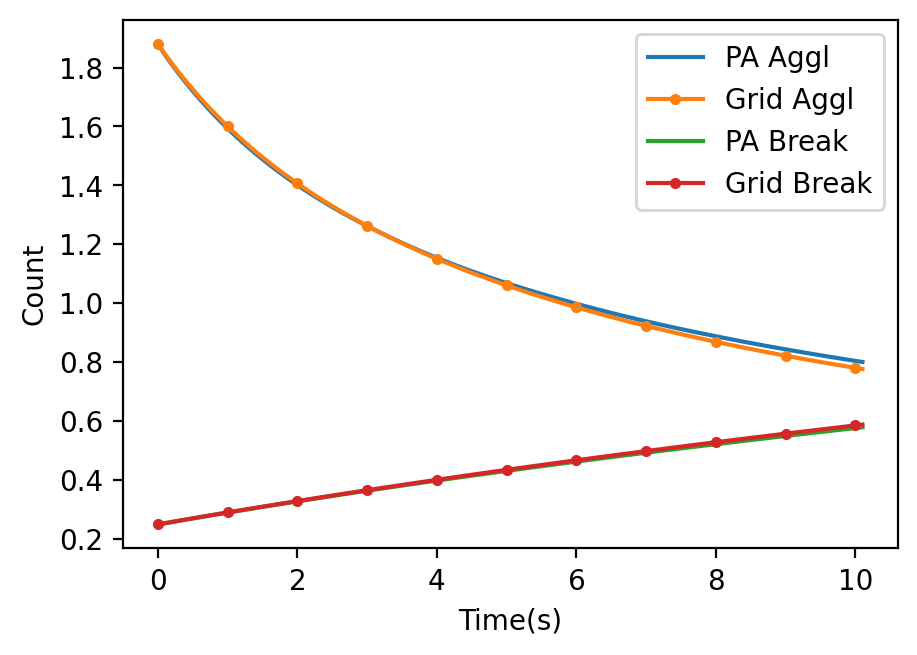

In [489]:
# Count profile
fig, ax = plt.subplots(dpi=200, figsize=(5, 3.5))
for d, lb, sym in zip(dataset, labels, symbols):
    ax.plot(d["ts"], d["cnts"], sym, label=lb, markevery=10)
ax.set_xlabel("Time(s)")
ax.set_ylabel("Count")
ax.legend()
save_fig(fig, "agg_brk_2d_count_profile")

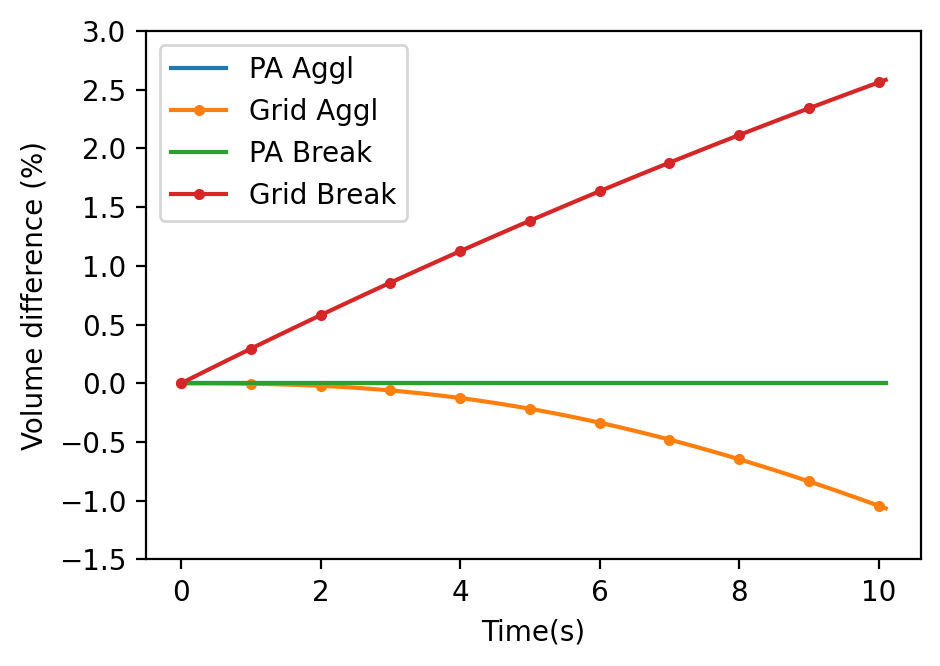

In [491]:
# Count profile
fig, ax = plt.subplots(dpi=200, figsize=(5, 3.5))
dataset = [aggl_pa, aggl_grid, brk_pa, brk_grid]
for d, lb, sym in zip(dataset, labels, symbols):
    ax.plot(d["ts"], (d["vols"] - d["vols"][0]) / d["vols"][0] * 100, sym, label=lb, markevery=10)
ax.set_xlabel("Time(s)")
ax.set_ylabel("Volume difference (%)")
ax.legend()
ax.set_ylim([-1.5, 3])
save_fig(fig, "agg_brk_2d_vol_difference_profile")

In [474]:
pa_dataset = [aggl_pa, brk_pa]
grid_dataset = [aggl_grid, brk_grid]


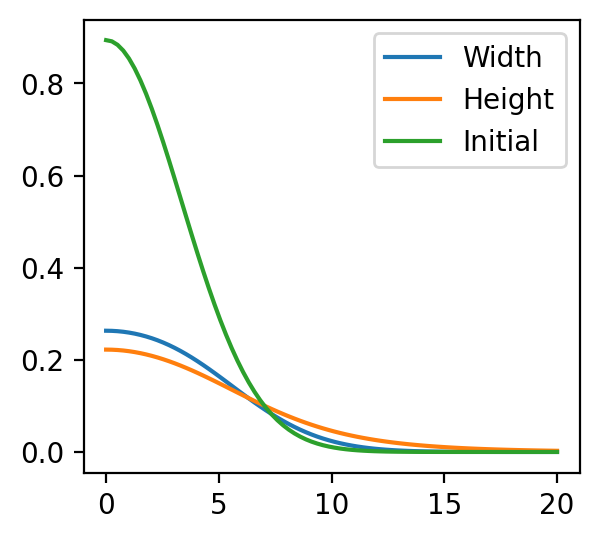

In [475]:
from scipy.stats import gaussian_kde
def kde_fcn(N, dim, low, high, npoints=80, bw=0.5, mirrored=True):
    N = N.copy()
    if mirrored:
        mirror = N.copy()
        mirror[:, dim] *= -1
        N = np.vstack([N, mirror])
        w = N[:, -1]
    else:
        w = N[:, -1]
    
    kde = gaussian_kde(N[:, dim], weights=w, bw_method=bw)
    x = np.linspace(low, high, npoints)
    y = kde(x) * 2 * N[:, -1].sum()
    return x, y 
    
N = aggl_pa["N"]
N_init = aggl_pa["N_init"]

fig, ax = plt.subplots(dpi=200, figsize=(3.2, 3))
x, y = kde_fcn(N, 0, 0., 20.)
ax.plot(x, y, label="Width")

x, y = kde_fcn(N, 1, 0., 20.)
ax.plot(x, y, label="Height")


x, y = kde_fcn(N_init, 0, 0., 20.)
ax.plot(x, y, label="Initial")
ax.legend()

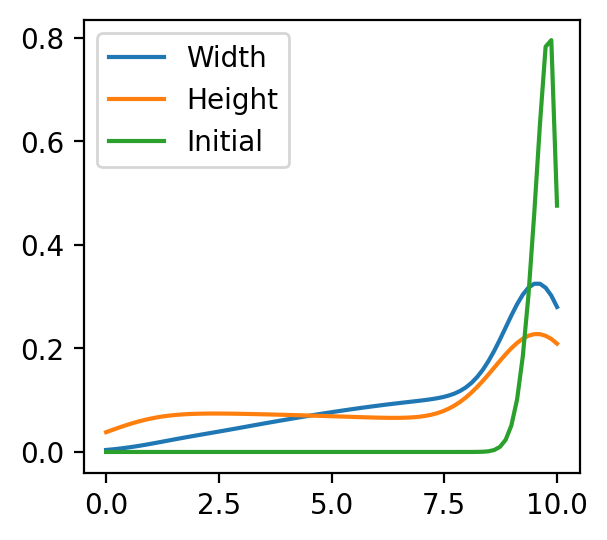

In [477]:
N = brk_pa["N"]
N_init = brk_pa["N_init"]

fig, ax = plt.subplots(dpi=200, figsize=(3.2, 3))
x, y = kde_fcn(N, 0, 0., 10., bw=0.3, mirrored=False)
ax.plot(x, y, label="Width")

x, y = kde_fcn(N, 1, 0., 10., bw=0.3, mirrored=False)
ax.plot(x, y, label="Height")


x, y = kde_fcn(N_init, 0, 0., 10., bw=0.5, mirrored=False)
ax.plot(x, y, label="Initial")
ax.legend()

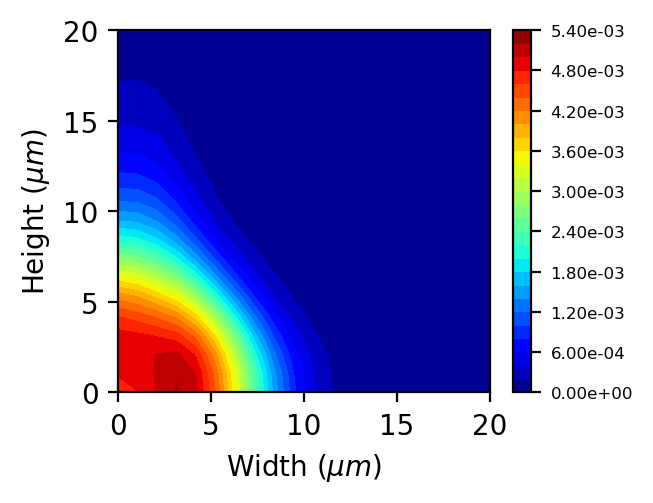

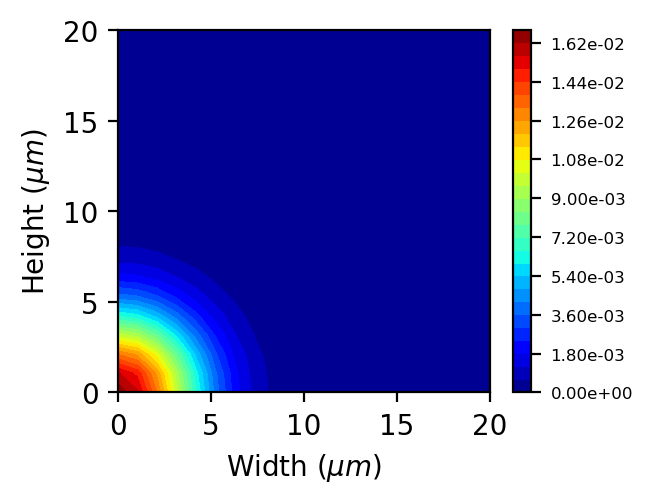

In [487]:
from scipy.stats import gaussian_kde
def kde_fcn_2d(N, low, high, npoints=80, bw=0.5, mirrored=True):
    N = N.copy()
    if mirrored:
        mirror = N.copy()
        mirror[:, 0] *= -1
        N = np.vstack([N, mirror])
        
        mirror = N.copy()
        mirror[:, 1] *= -1
        N = np.vstack([N, mirror])

    
    kde = gaussian_kde(N[:, :-1].T, weights=N[:, -1], bw_method=bw)
    
    lg = np.linspace(low, high, npoints)
    grids = np.meshgrid(lg, lg)
    
    unravel_grid = np.stack(grids, axis=-1).reshape((-1, 2)).T
    y = kde(unravel_grid).reshape((npoints, npoints))
    return grids, y 


N = aggl_pa["N"]
N_init = aggl_pa["N_init"]

fig, ax = plt.subplots(dpi=200, figsize=(3.0, 2.4))
x, y = kde_fcn_2d(N, 0., 20., npoints=20, bw=0.25)
cset = ax.contourf(x[0], x[1], y, cmap="jet", levels=30)
ax.set_xlabel("Width $(\mu m)$")
ax.set_ylabel("Height $(\mu m)$")
cbar = fig.colorbar(cset, format='%.2e')
cbar.ax.tick_params(labelsize=6)
save_fig(fig, "agglomeration_contour_end_2d")

fig, ax = plt.subplots(dpi=200, figsize=(3.0, 2.4))
x, y = kde_fcn_2d(N_init, 0., 20., npoints=20, bw=0.25)
cset = ax.contourf(x[0], x[1], y, cmap="jet", levels=30)
ax.set_xlabel("Width $(\mu m)$")
ax.set_ylabel("Height $(\mu m)$")
cbar = fig.colorbar(cset, format='%.2e')
cbar.ax.tick_params(labelsize=6)
save_fig(fig, "agglomeration_contour_init_2d")

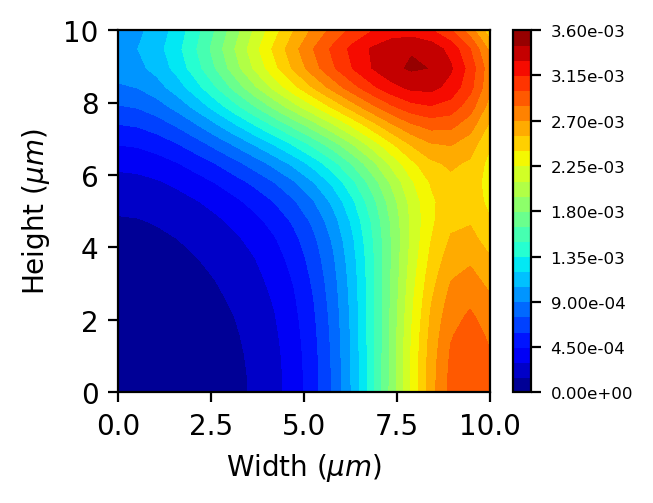

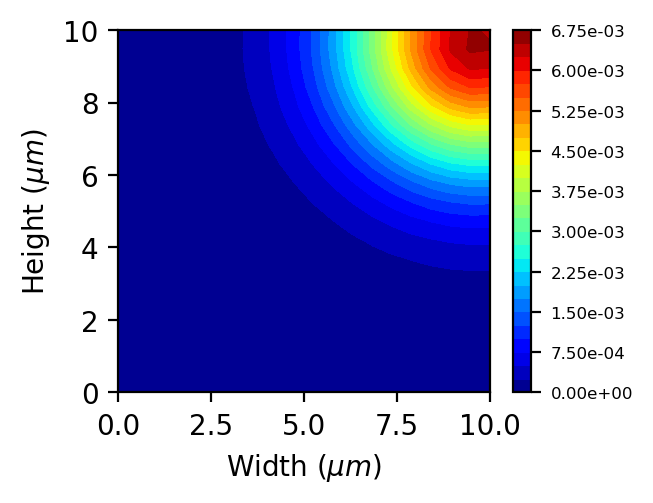

In [488]:
N = brk_pa["N"]
N_init = brk_pa["N_init"]

fig, ax = plt.subplots(dpi=200, figsize=(3.0, 2.4))
x, y = kde_fcn_2d(N, 0., 10., npoints=20, bw=0.25)
cset = ax.contourf(x[0], x[1], y, cmap="jet", levels=30)
ax.set_xlabel("Width $(\mu m)$")
ax.set_ylabel("Height $(\mu m)$")
cbar = fig.colorbar(cset, format='%.2e')
cbar.ax.tick_params(labelsize=6)
save_fig(fig, "brk_contour_end_2d")


fig, ax = plt.subplots(dpi=200, figsize=(3.0, 2.4))
x, y = kde_fcn_2d(N_init, 0., 10., npoints=20, bw=0.25)
cset = ax.contourf(x[0], x[1], y, cmap="jet", levels=30)
ax.set_xlabel("Width $(\mu m)$")
ax.set_ylabel("Height $(\mu m)$")
cbar = fig.colorbar(cset, format='%.2e')
cbar.ax.tick_params(labelsize=6)
save_fig(fig, "brk_contour_init_2d")
